In [ ]:
#### now add the mapillary info

In [15]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

### get mapillary_coverage

In [16]:
# ndissolved works well, however rather want to work with dissolved and cut TODOO

#mapillary_coverage = gpd.read_parquet(r"../../mapillary/mapillary_coverage_23_bb_buffered10m_dissolved.parquet")
mapillary_coverage = gpd.read_parquet(r"mapillary_coverage_23_bb_buffered10m_ndissolved.parquet")

In [17]:
## nur für pano
mapillary_coverage=mapillary_coverage[mapillary_coverage["is_pano"]==True].copy()

mapillary_coverage = mapillary_coverage.to_crs(25832)

mapillary_clean = mapillary_coverage.explode(index_parts=False, ignore_index=True)

### get the roads of interest

In [18]:
# osm_roads_2024_intersect_landuse.to_parquet("../output/roads_wo_maxspeed&accs_2024_urban.parquet")
osm_roads_2024_intersect_landuse = gpd.read_parquet("../osm_history_analysis/output/roads_wo_maxspeed&accs_2024_urban.parquet")

In [19]:
osm_roads_2024_intersect_landuse['length_km_before_clip'] = osm_roads_2024_intersect_landuse.geometry.length
osm_roads_2024_intersect_landuse

,highway,maxspeed,maxspeed:conditional,maxspeed:type,maxspeed:forward,maxspeed:backward,zone:traffic,id_left,geometry,year_left,count_accidents,index_right,landuse,id_right,year_right,length_km_before_clip
353,primary,None,None,None,None,None,None,4440904,"MULTILINESTRING ((877139.327 5813995.667, 8771...",2024,2,0,commercial,3220314,2024,429.813023
354,primary,None,None,None,None,None,None,4440936,"MULTILINESTRING ((875805.927 5831583.116, 8758...",2024,3,0,commercial,3220314,2024,984.864398
355,secondary,None,None,None,None,None,None,4440939,"MULTILINESTRING ((876260.422 5837563.557, 8762...",2024,2,0,commercial,3220314,2024,618.789356
363,primary,None,None,None,None,None,None,4449161,"MULTILINESTRING ((778571.996 5821309.245, 7785...",2024,2,0,commercial,3220314,2024,35.483177
426,primary_link,None,None,None,None,None,None,4541553,"MULTILINESTRING ((723269.678 5831570.032, 7232...",2024,3,0,commercial,3220314,2024,394.845855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81505,tertiary,None,None,None,None,None,None,1231574469,"LINESTRING (804968.442 5718111.064, 804958.025...",2024,1,0,commercial,3220314,2024,15.978136
81506,secondary,None,None,None,None,None,None,1231575213,"LINESTRING (805715.148 5718832.638, 805716.655...",2024,1,0,commercial,3220314,2024,20.146320
81527,primary,None,None,None,None,None,None,1232198467,"MULTILINESTRING ((868683.564 5792330.049, 8686...",2024,1,0,commercial,3220314,2024,484.746780
81528,primary,None,None,None,None,None,None,1232198468,"MULTILINESTRING ((868283.762 5792598.592, 8682...",2024,1,0,commercial,3220314,2024,30.828617


In [22]:
from shapely.geometry import box

def spatial_filter(gdf, geom):
    idx = gdf.sindex.query(geom, predicate="intersects")
    return gdf.iloc[idx]


#sample=osm_roads_2024_intersect_landuse[:1500].copy()
#sample=osm_roads_2024_intersect_landuse.copy()


clipped_lines = []

clipped_gdf = gpd.GeoDataFrame()

for _, row in osm_roads_2024_intersect_landuse.iterrows():
    bbox = box(*row.geometry.bounds)
    #filtered_polys = mapillary_clean[mapillary_clean.intersects(bbox)]
    filtered_polys = spatial_filter(mapillary_clean, bbox) # 3times faster than intersects
    
    if not filtered_polys.empty:
        clipped = gpd.clip(gpd.GeoDataFrame([row], crs=osm_roads_2024_intersect_landuse.crs), filtered_polys)
        clipped_lines.append(clipped)

# Combine all results
clipped_gdf = gpd.GeoDataFrame(pd.concat(clipped_lines, ignore_index=True), crs=osm_roads_2024_intersect_landuse.crs)


In [23]:
clipped_gdf['length_km_after_clip'] = clipped_gdf.geometry.length

clipped_gdf["mp_coverage_ratio"] = clipped_gdf["length_km_after_clip"] / clipped_gdf["length_km_before_clip"]



<Axes: >

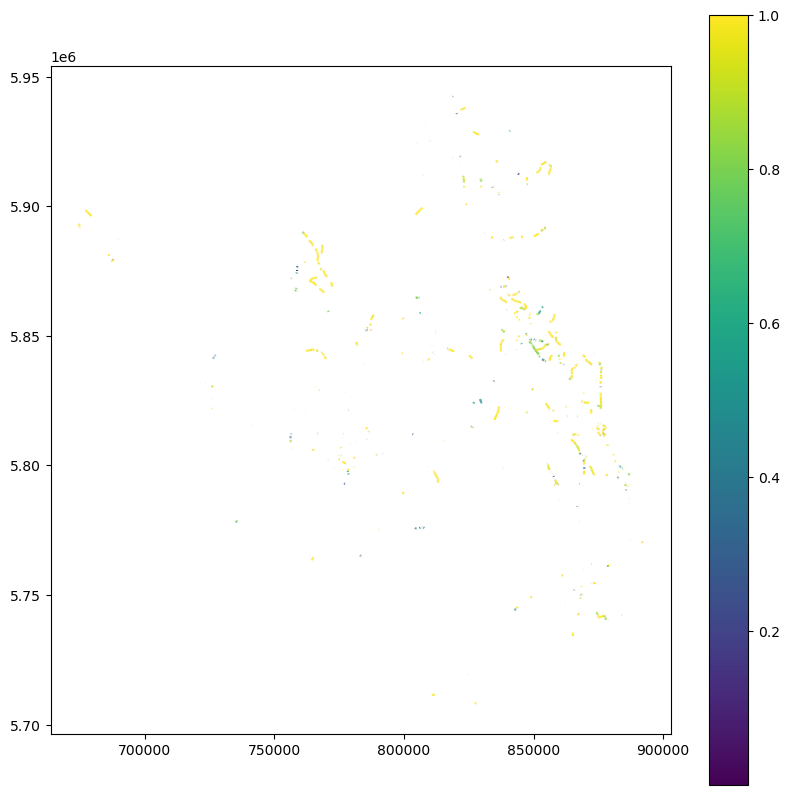

In [25]:
clipped_gdf.plot(column="mp_coverage_ratio", cmap="viridis", legend=True, figsize=(10, 10))

array([[<Axes: title={'center': 'mp_coverage_ratio'}>]], dtype=object)

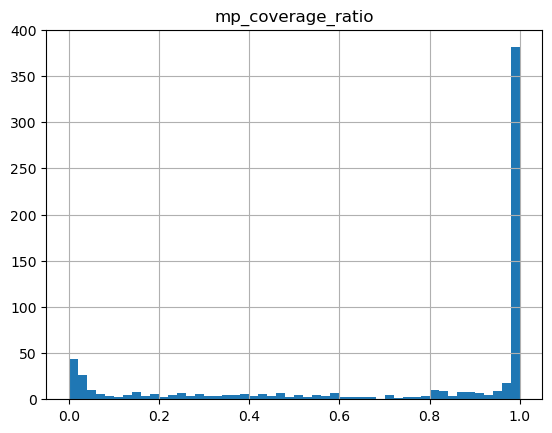

In [26]:
clipped_gdf.hist(column="mp_coverage_ratio", bins=50)

In [27]:
clipped_gdf.columns

Index(['highway', 'maxspeed', 'maxspeed:conditional', 'maxspeed:type',
       'maxspeed:forward', 'maxspeed:backward', 'zone:traffic', 'id_left',
       'geometry', 'year_left', 'count_accidents', 'index_right', 'landuse',
       'id_right', 'year_right', 'length_km_before_clip',
       'length_km_after_clip', 'mp_coverage_ratio'],
      dtype='object')

In [28]:
clipped_gdf=clipped_gdf[["count_accidents","mp_coverage_ratio", "length_km_before_clip", "length_km_after_clip", "geometry"]].copy()

In [29]:
## mapillary coverage ratio > 0.9 and more than 5 accidents
clipped_gdf[(clipped_gdf["mp_coverage_ratio"]>0.9) & (clipped_gdf["count_accidents"]>5)].sort_values("count_accidents", ascending=False)#[:10]

,count_accidents,mp_coverage_ratio,length_km_before_clip,length_km_after_clip,geometry
499,17,1.000000,3570.739151,3570.739151,"MULTILINESTRING ((807189.825 5899384.149, 8071..."
202,16,0.984963,1157.671062,1140.263441,"MULTILINESTRING ((877631.741 5815021.67, 87758..."
51,13,1.000000,3217.424470,3217.424470,"MULTILINESTRING ((766271.25 5872594.409, 76624..."
106,13,1.000000,124.387861,124.387861,"MULTILINESTRING ((876990.478 5812558.281, 8769..."
465,13,0.963881,62.383172,60.129928,"MULTILINESTRING ((885658.041 5792844.681, 8856..."
118,12,1.000000,27.961368,27.961368,"LINESTRING (776527.038 5812251.771, 776554.964..."
78,12,1.000000,419.139579,419.139579,"MULTILINESTRING ((876569.701 5813006.453, 8765..."
140,11,1.000000,394.612796,394.612796,"MULTILINESTRING ((864520.95 5833828.965, 86454..."
522,11,0.918436,52.551354,48.265034,"MULTILINESTRING ((854269.764 5891514.339, 8542..."
375,11,1.000000,79.528541,79.528541,"MULTILINESTRING ((785204.692 5852147.816, 7852..."


In [18]:
", ".join(map(str, clipped_gdf[(clipped_gdf["mp_coverage_ratio"]>0.9) & (clipped_gdf["count_accidents"]>5)]["id_left"].tolist()))

'8771096, 8771449, 23692730, 24557971, 26366673, 27184171, 27559768, 27808137, 29328005, 29983376, 30051383, 31276463, 35873927, 43386271, 59967943, 75377412, 101184512, 118977398, 128284101, 133747274, 148460813, 195646079, 198818952, 203255928, 301255839, 315144264, 317429966, 344361833, 384301112, 396428806, 438295593, 480741228, 589442136, 631801746, 719920525, 764551238, 769167196, 826562518, 966803908, 997214442, 1172690403, 1207837737, 1218403543'